In [3]:
!pip install PennyLane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 86.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.8 MB/s eta 0:00:00


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os
import cv2
import time 
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
import pennylane as qml
from torchmetrics.classification import MulticlassF1Score,MulticlassRecall,MulticlassPrecision,MulticlassAccuracy,MulticlassConfusionMatrix

# Loading the Dataset

In [5]:
train_path = '/kaggle/input/tig-aluminium-5083/al5083/train/'
test_path = '/kaggle/input/tig-aluminium-5083/al5083/test/'

labels_ = {'0':'good weld',
          '1':'burn through',
          '2':'contamination',
          '3':'lack of fusion',
          '4':'misalignment',
          '5':'lack of penetration'}

In [6]:
# Loading the json files consisting of train and test image paths and labels

train_dict_ = json.load(open(train_path + 'train.json'))
test_dict_ = json.load(open(test_path + 'test.json'))

In [7]:
# Getting the image paths and labels in a list

def get_data_from_dict(data_dict_,ds):
    img_paths_ = list(data_dict_.keys())
    labels = list(data_dict_.values())
    print(f"No. of {ds} Images {len(img_paths_)}")
    return img_paths_,labels

In [8]:
train_img_paths,train_labels = get_data_from_dict(train_dict_,'train')
test_img_paths,test_labels = get_data_from_dict(test_dict_,'test')

No. of train Images 26666
No. of test Images 6588


In [9]:
# Displaying the image and printing the respective label with index

def plot_image(img_paths_,labels,random=True):
    if random:
        i = np.random.choice(len(img_paths_))
        print(i)
    key = img_paths_[i]
    label = str(labels[i])
    im_path = train_path + key.split('/')[-2] + '/' + key.split('/')[-1]
    img = cv2.imread(im_path)
    plt.imshow(img);
    plt.title(labels_[label])
    plt.show()

2118


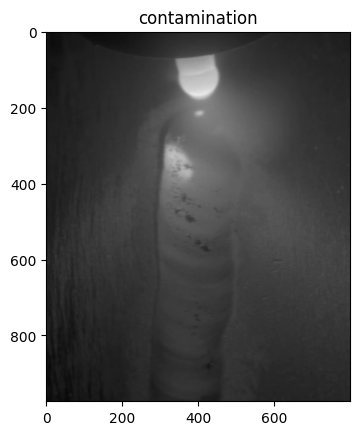

In [10]:
plot_image(train_img_paths,train_labels)

In [11]:
# Storing the image paths and labels in a pandas dataframe

def get_df(img_paths,labels):
    new_df = pd.DataFrame()
    new_df['Images'] = img_paths
    new_df['Labels'] = labels
    new_df.insert(2,'Label Names',[labels_[str(val)] for val in new_df['Labels']])
    
    return new_df

In [12]:
Train_df = get_df(train_img_paths,train_labels)
Test_df = get_df(test_img_paths,test_labels)

In [13]:
Train_df.Labels.value_counts()

Labels
0    8758
2    6325
3    4028
4    2953
5    2819
1    1783
Name: count, dtype: int64

# Plotting the Label counts

## Count of labels in Train dataset

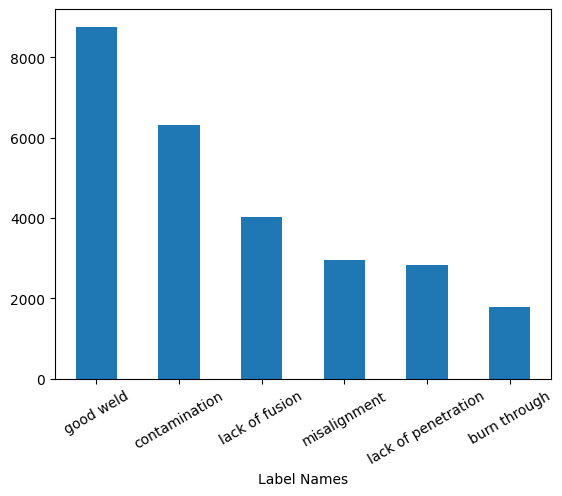

In [14]:
Train_df['Label Names'].value_counts().plot(kind='bar',rot=30);

## Count of labels in Test dataset

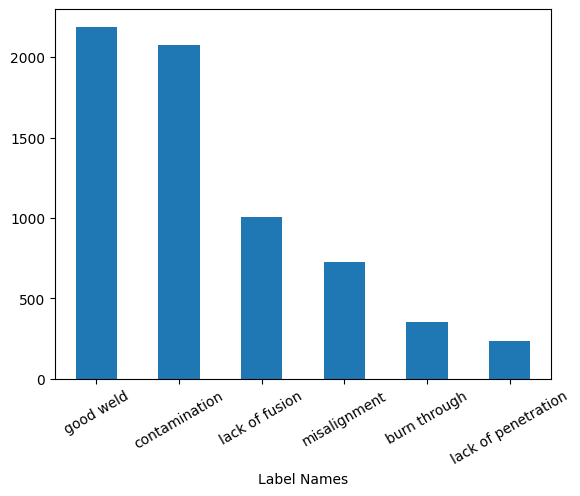

In [15]:
Test_df['Label Names'].value_counts().plot(kind='bar',rot=30);

In [16]:
Test_df['Label Names'].value_counts()

Label Names
good weld              2189
contamination          2078
lack of fusion         1007
misalignment            729
burn through            351
lack of penetration     234
Name: count, dtype: int64

In [17]:
labels_.values()

dict_values(['good weld', 'burn through', 'contamination', 'lack of fusion', 'misalignment', 'lack of penetration'])

# Balancing the Train and Test Labels

In [18]:
train_dfs_list = []
test_dfs_list = []

for lbl in labels_.values():
    if lbl == 'burn through':
        train_dfs_list.append(Train_df[Train_df['Label Names'] == lbl])
    else:
        train_dfs_list.append(Train_df[Train_df['Label Names'] == lbl].sample(2000))

for lbl in labels_.values():
    test_dfs_list.append(Test_df[Test_df['Label Names'] == lbl].sample(230))
        
train_df_final = pd.concat(train_dfs_list)
test_df_final = pd.concat(test_dfs_list)

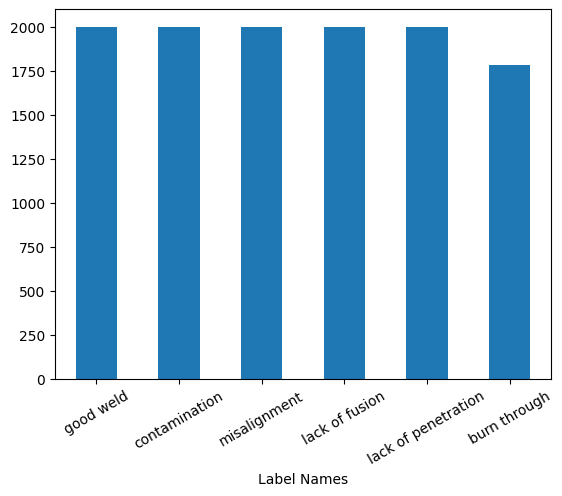

In [19]:
train_df_final['Label Names'].value_counts().plot(kind='bar',rot=30);

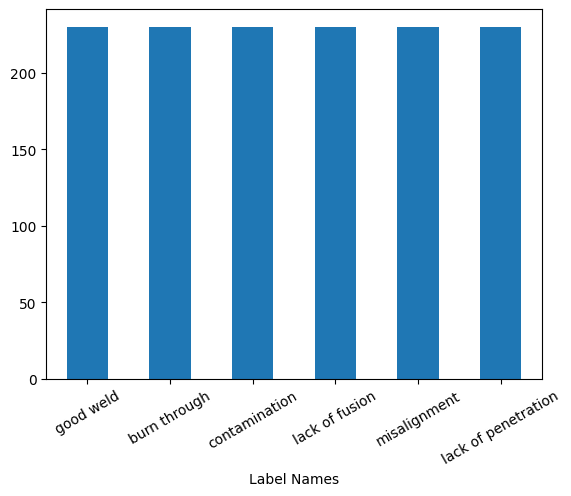

In [20]:
test_df_final['Label Names'].value_counts().plot(kind='bar',rot=30);

In [21]:
train_df_final.Images = train_path + train_df_final.Images
test_df_final.Images = test_path + test_df_final.Images

In [22]:
# Splitting the train and test set with 70-30 split

Total_df = pd.concat([train_df_final,test_df_final])

X = Total_df.drop('Labels',axis=1)
y = Total_df.Labels

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,stratify=y,random_state=2529)

In [23]:
Train_dff = pd.concat([X_train,y_train],axis=1)
Test_dff = pd.concat([X_test,y_test],axis=1)

In [24]:
Train_dff#.Labels.value_counts()

,Images,Label Names,Labels
2740,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
20466,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
23177,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3
4312,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
702,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1
...,...,...,...
21235,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
22476,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
17175,/kaggle/input/tig-aluminium-5083/al5083/train/...,good weld,0
22839,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3


In [26]:
Test_dff

,Images,Label Names,Labels
17987,/kaggle/input/tig-aluminium-5083/al5083/train/...,good weld,0
226,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1
425,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1
23507,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3
6288,/kaggle/input/tig-aluminium-5083/al5083/test/1...,lack of fusion,3
...,...,...,...
19820,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
5025,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
3232,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
26274,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3


In [27]:
train_df_final = pd.concat([Train_dff,pd.get_dummies(Train_dff.Labels, dtype=int)],axis=1)
test_df_final = pd.concat([Test_dff,pd.get_dummies(Test_dff.Labels, dtype=int)],axis=1)

In [28]:
test_df_final.head()

,Images,Label Names,Labels,0,1,2,3,4,5
17987,/kaggle/input/tig-aluminium-5083/al5083/train/...,good weld,0,1,0,0,0,0,0
226,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1,0,1,0,0,0,0
425,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1,0,1,0,0,0,0
23507,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3,0,0,0,1,0,0
6288,/kaggle/input/tig-aluminium-5083/al5083/test/1...,lack of fusion,3,0,0,0,1,0,0


# Define the Torch Dataset

In [30]:
class DataSet_gen(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df

    def __getitem__(self,index):
        im_path = self.df.iloc[index].values[0]
        label = self.df.iloc[index].values[2]
        img = cv2.imread(im_path)
        img = cv2.resize(img, (256, 256))
        img = img.astype(np.float32)
        img = img/255.
        img = torch.from_numpy(img).permute(2, 0, 1)

        return img,label

    def __len__(self):
        return len(self.df)

In [31]:
trainset = DataSet_gen(train_df_final)
testset = DataSet_gen(test_df_final)

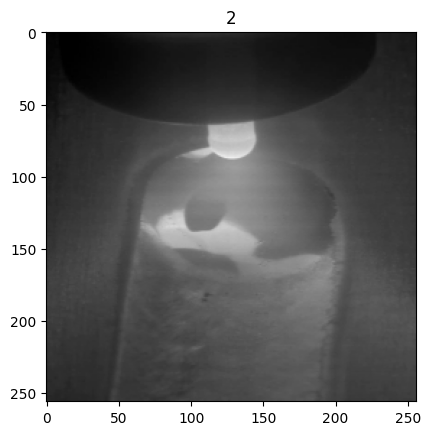

In [32]:
plt.imshow(trainset[0][0].permute(1,2,0));
plt.title(trainset[0][1])
plt.show()

In [33]:
# Defining the train and test loader that will be required for training and testing

train_loader = DataLoader(dataset=trainset,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset=testset,batch_size=64,shuffle=False)

# Train and Test set size

In [34]:
len(trainset), len(testset)

(9214, 3949)

In [35]:
for images, labels in train_loader:
    break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([64, 3, 256, 256])
One batch label shape : torch.Size([64])


In [36]:
dev = qml.device("default.qubit", wires=6)

@qml.qnode(dev)
def qnode(inputs, weights):
    n_qubits = 6
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Defining the Hybrid CNN Model

In [37]:
class ImageModel(nn.Module):
    def __init__(self,qnode):
        super(ImageModel, self).__init__()
        
        weight_shapes = {"weights": (6,6)} # Defining the shape of weights
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes) # Torch layer consisting of device and weight shapes
      
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
            nn.ReLU(),
        )

        self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride=2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216,6400),
            nn.ReLU(),
            nn.Linear(6400,2048),
            nn.ReLU(),
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Linear(512,6),
            qml.qnn.TorchLayer(qnode, weight_shapes), ## Passing the torch layer
            nn.Linear(6,6)
        )

        self.gradient = None

    def activation_hook(self,grad): #get gradients
        self.gradient = grad

    def forward(self,images):
        x = self.feature_extractor(images) #activation_maps
        if x.requires_grad:
            h =  x.register_hook(self.activation_hook)
        x = self.maxpool(x)
        x = self.classifier(x)
        x = self.qlayer(x)

        return x

    def get_activation_gradients(self): #a1,a2... (weights)
        return self.gradient

    def get_activation(self,x):
        return self.feature_extractor(x)

In [38]:
# Setting the device to cuda as we will be running our experiments on GPU

device = 'cuda'

model = ImageModel(qnode)
model.to(device)

ImageModel(
  (qlayer): <Quantum Torch Layer: func=qnode>
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=6400, bias=True)
    (2): ReLU()
    (3): Linear(in_features=6

# Training function to train the model

In [39]:
def train_fn(dataloader,model,optimizer,criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for images,labels in tqdm(dataloader,colour='blue'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits,labels)
        
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    accuracy = 100 * total_correct / total_samples
    
    return total_loss / len(dataloader), accuracy

#  Eval function to test the model

In [40]:
def eval_fn(dataloader,model,criterion):
    model.eval()
    total_correct = 0
    total_loss = 0.0
    total_samples = 0
    
    for images,labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits,labels)
        
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        total_loss += loss.item()

    accuracy = 100 * total_correct / total_samples
    return total_loss / len(dataloader),accuracy

In [41]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# Model Training

In [42]:
best_valid_loss = np.Inf
useful_stuff = {'training_loss':[],'training_accuracy':[],
                'testing_loss':[],'testing_accuracy':[]}

begin = time.time() 

for i in range(20):
    train_loss,train_acc = train_fn(train_loader,model,optimizer,criterion)
    test_loss,test_acc = eval_fn(test_loader,model,criterion)
    
    useful_stuff['training_loss'].append(train_loss)
    useful_stuff['training_accuracy'].append(train_acc)

    useful_stuff['testing_loss'].append(test_loss)
    useful_stuff['testing_accuracy'].append(test_acc)

    if test_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_weights_.pt')
        best_valid_loss = test_loss
        print("Weights savedd.")

    print(f'Epoch: {i+1} Train Loss: {train_loss} Train Accuracy: {train_acc} Test Loss: {test_loss} Test Accuracy: {test_acc}')

end = time.time()  
# total time taken 
print(f"Total runtime of the QCNN Model is {end - begin}") 

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 1 Train Loss: 1.7562786183423467 Train Accuracy: 23.789884957673106 Test Loss: 1.6978428844482667 Test Accuracy: 35.19878450240567


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 2 Train Loss: 1.6150079526835017 Train Accuracy: 40.39505100933362 Test Loss: 1.5525080984638584 Test Accuracy: 48.240060774879716


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 3 Train Loss: 1.5174266041980848 Train Accuracy: 54.66681137399609 Test Loss: 1.4635793816658758 Test Accuracy: 62.6487718409724


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 4 Train Loss: 1.4314118408494525 Train Accuracy: 64.4996744085088 Test Loss: 1.3990929530512901 Test Accuracy: 68.21980248164093


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 5 Train Loss: 1.3688530069258478 Train Accuracy: 78.90167136965488 Test Loss: 1.3472137604990313 Test Accuracy: 80.7292985565966


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 6 Train Loss: 1.3211347659428914 Train Accuracy: 81.94052528760582 Test Loss: 1.3006897357202345 Test Accuracy: 91.59280830590023


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 7 Train Loss: 1.286743250158098 Train Accuracy: 90.74234859995659 Test Loss: 1.2779413480912485 Test Accuracy: 95.54317548746518


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 8 Train Loss: 1.260913492904769 Train Accuracy: 97.27588452355111 Test Loss: 1.2388897153639025 Test Accuracy: 98.98708533806027


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 9 Train Loss: 1.2216595543755426 Train Accuracy: 98.66507488604297 Test Loss: 1.201716826808068 Test Accuracy: 97.59432767789313


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 1.183533578283257 Train Accuracy: 97.24332537443021 Test Loss: 1.245142650219702 Test Accuracy: 85.18612306913143


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 11 Train Loss: 1.1825835953156154 Train Accuracy: 94.44323855003256 Test Loss: 1.1697920695427926 Test Accuracy: 94.40364649278298


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 12 Train Loss: 1.155549822582139 Train Accuracy: 94.04167571087476 Test Loss: 1.1572092867666675 Test Accuracy: 91.64345403899722


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 13 Train Loss: 1.1394690035117998 Train Accuracy: 96.36422834816584 Test Loss: 1.1366737523386556 Test Accuracy: 96.37883008356546


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 14 Train Loss: 1.111288079784976 Train Accuracy: 98.26351204688517 Test Loss: 1.1059355370460018 Test Accuracy: 98.53127374018739


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 1.0982327254282103 Train Accuracy: 98.74104623399175 Test Loss: 1.111443167732608 Test Accuracy: 96.68270448214737


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 16 Train Loss: 1.0950235194630094 Train Accuracy: 98.76275233340569 Test Loss: 1.091833939475398 Test Accuracy: 99.18966827044821


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 17 Train Loss: 1.0859559542602963 Train Accuracy: 99.62014326025613 Test Loss: 1.0900000218422181 Test Accuracy: 99.11369967080273


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 1.090956549677584 Train Accuracy: 99.13175602344259 Test Loss: 1.0981114852812983 Test Accuracy: 97.89820207647506


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 1.0920227078927889 Train Accuracy: 98.80616453223355 Test Loss: 1.095230148684594 Test Accuracy: 98.55659660673588


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 1.091401023997201 Train Accuracy: 99.00151942695898 Test Loss: 1.095499990447875 Test Accuracy: 98.70853380602684
Total runtime of the QCNN Model is 3823.426735162735


# Model Loss

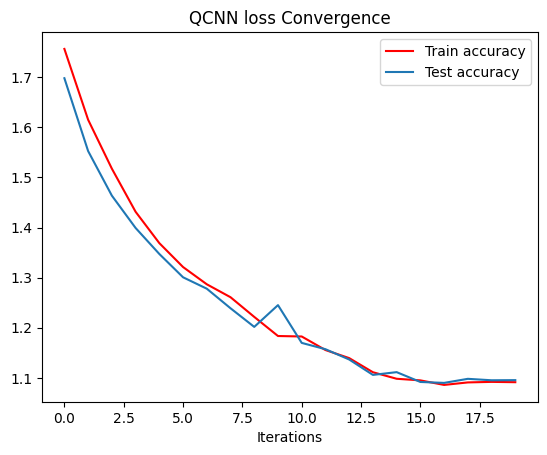

In [43]:
# Plot loss convergence
plt.plot(useful_stuff['training_loss'],'r')
plt.plot(useful_stuff['testing_loss'])
plt.title("QCNN loss Convergence")
plt.legend(["Train accuracy", "Test accuracy"], loc="upper right")
plt.xlabel("Iterations")
plt.show()

# Model Accuracy

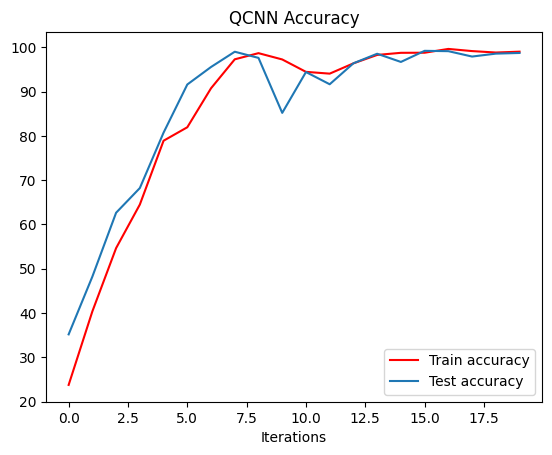

In [44]:
# Plot loss convergence
plt.plot(useful_stuff['training_accuracy'],'r')
plt.plot(useful_stuff['testing_accuracy'])
plt.title("QCNN Accuracy")
plt.xlabel("Iterations")
plt.legend(["Train accuracy", "Test accuracy"], loc="lower right")
plt.show()

**Gradient-weighted Class Activation Mapping
(Grad-CAM), uses the gradients of any target concept (say
‘dog’ in a classification network or a sequence of words
in captioning network) flowing into the final convolutional
layer to produce a coarse localization map highlighting the
important regions in the image for predicting the concept.**

In [45]:
def get_GradCam(model,image,label,size):
    label.backward()
    gradients = model.get_activation_gradients() #weights
    pooled_grads = torch.mean(gradients,dim=[0,2,3])
    activations = model.get_activation(image).detach() #get activation map

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(activations,dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(),(size,size))

    return heatmap

# Plot the heatmap on Image to see what regions has the model learned

In [46]:
def plot_heatmap(denorm_image, label,pred, heatmap):

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,20), ncols=3)

    classes = list(labels_.values())
    ps = torch.nn.Softmax(dim = 1)(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)
    ax1.set_title(classes[label],color='green')
    ax2.barh(classes, ps[0])
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    ax3.imshow(denorm_image)
    ax3.imshow(heatmap, cmap='magma', alpha=0.7)

In [47]:
labels_.values()

dict_values(['good weld', 'burn through', 'contamination', 'lack of fusion', 'misalignment', 'lack of penetration'])

# Lets understand the Model's Learning with the help of grad-CAM

## Example 1

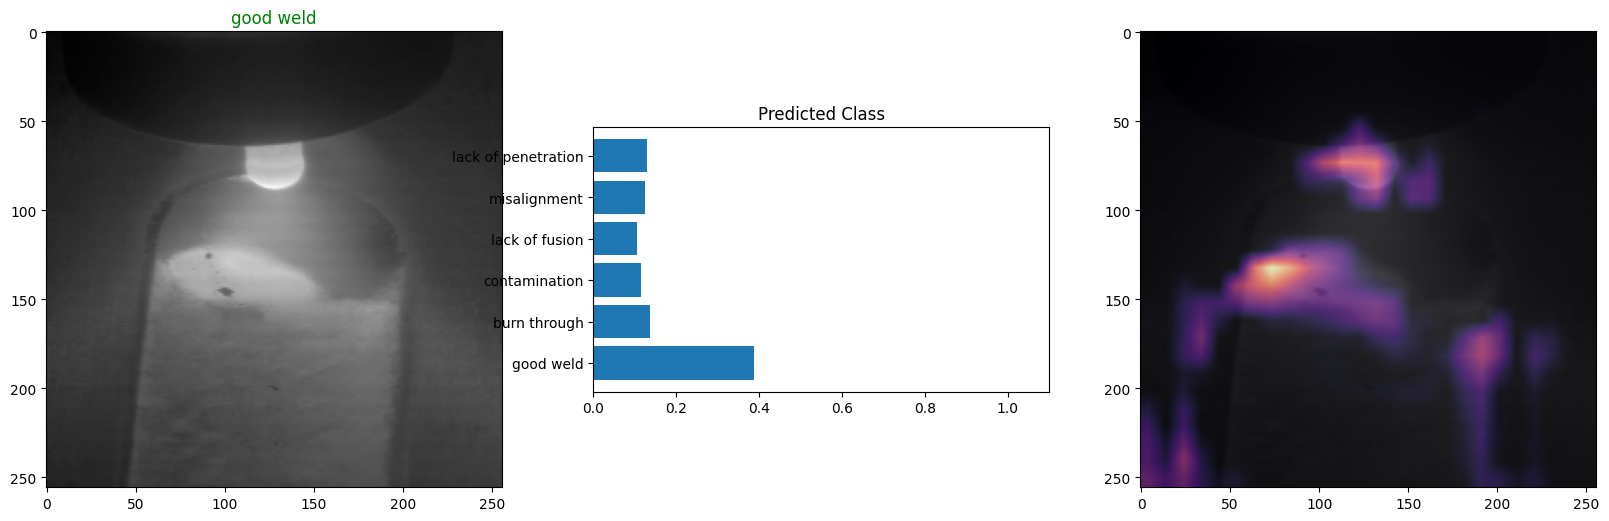

In [89]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[0]
denorm_image = image.permute(1,2,0) 
image = image.unsqueeze(0)
image = image.to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][0],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 2

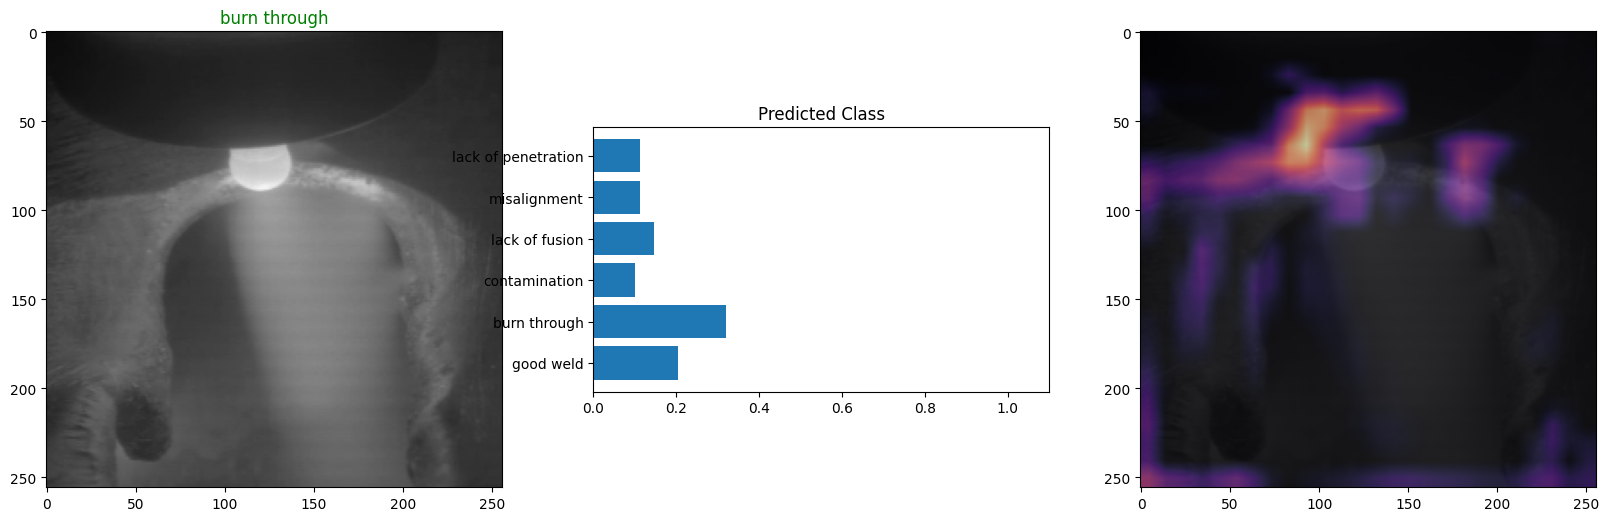

In [76]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'


image,label = testset[1]

denorm_image = image.permute(1,2,0) #* np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))

image = image.unsqueeze(0)#.to(device)
image = image.to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][1],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 3

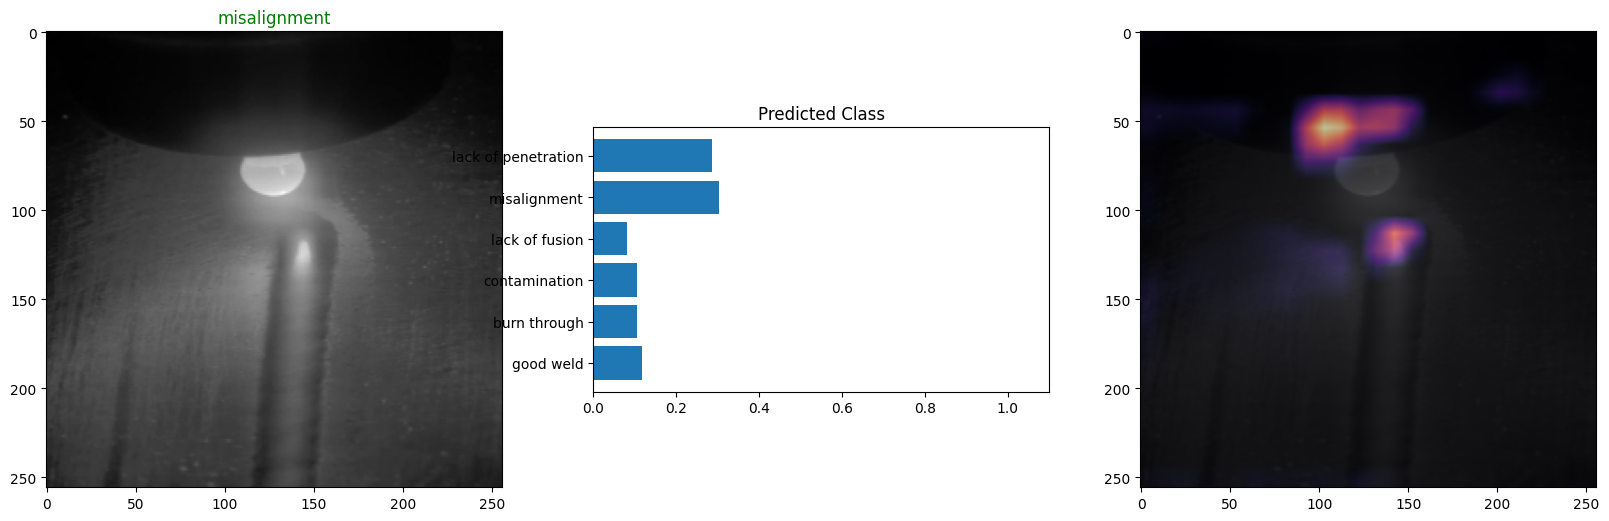

In [90]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[10]

denorm_image = image.permute(1,2,0) #* np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][4],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 4

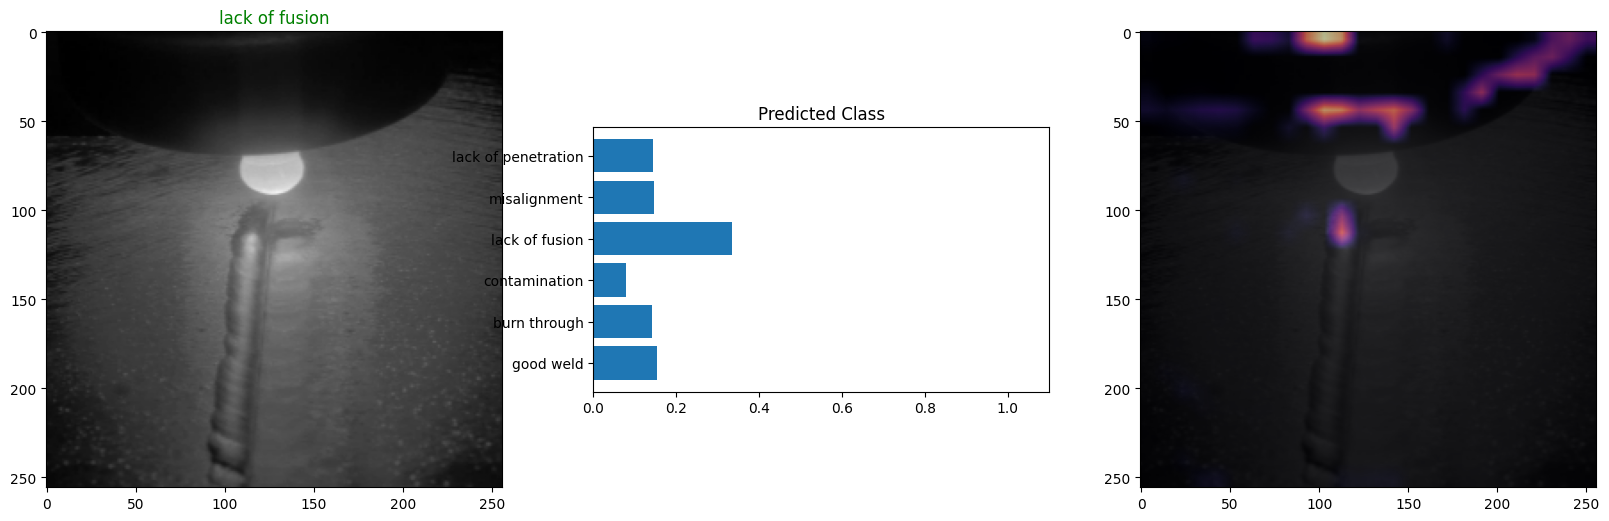

In [92]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[3]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][3],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 5

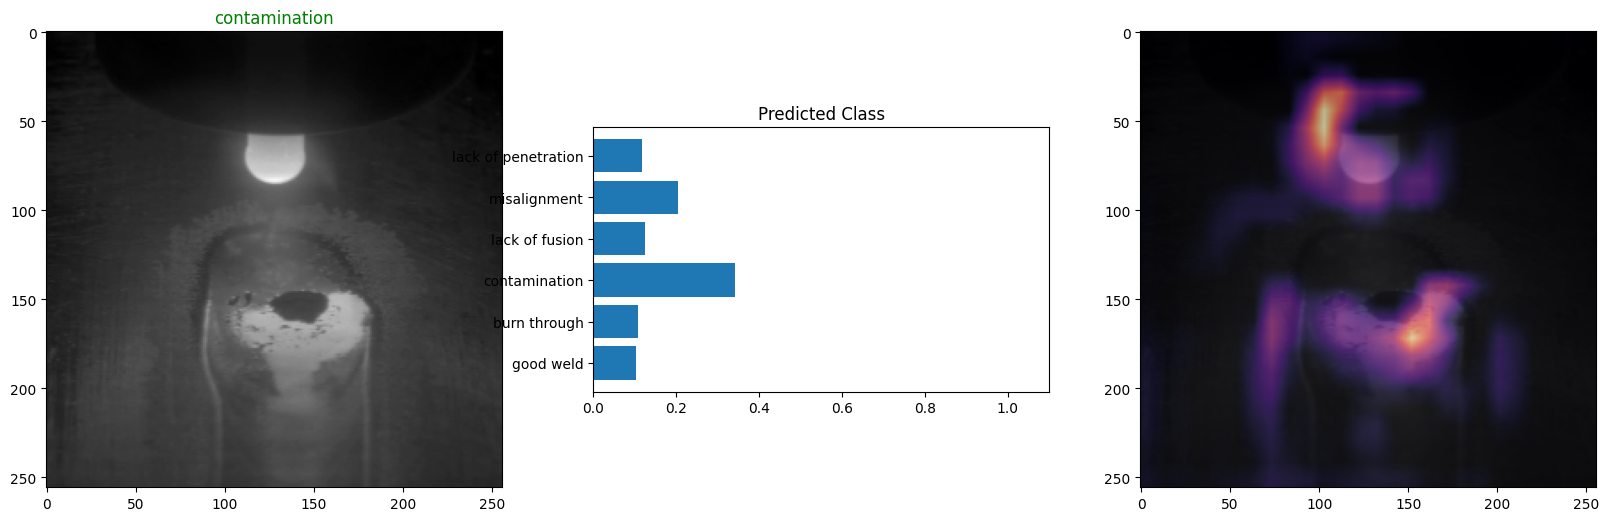

In [93]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[5]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][2],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 6

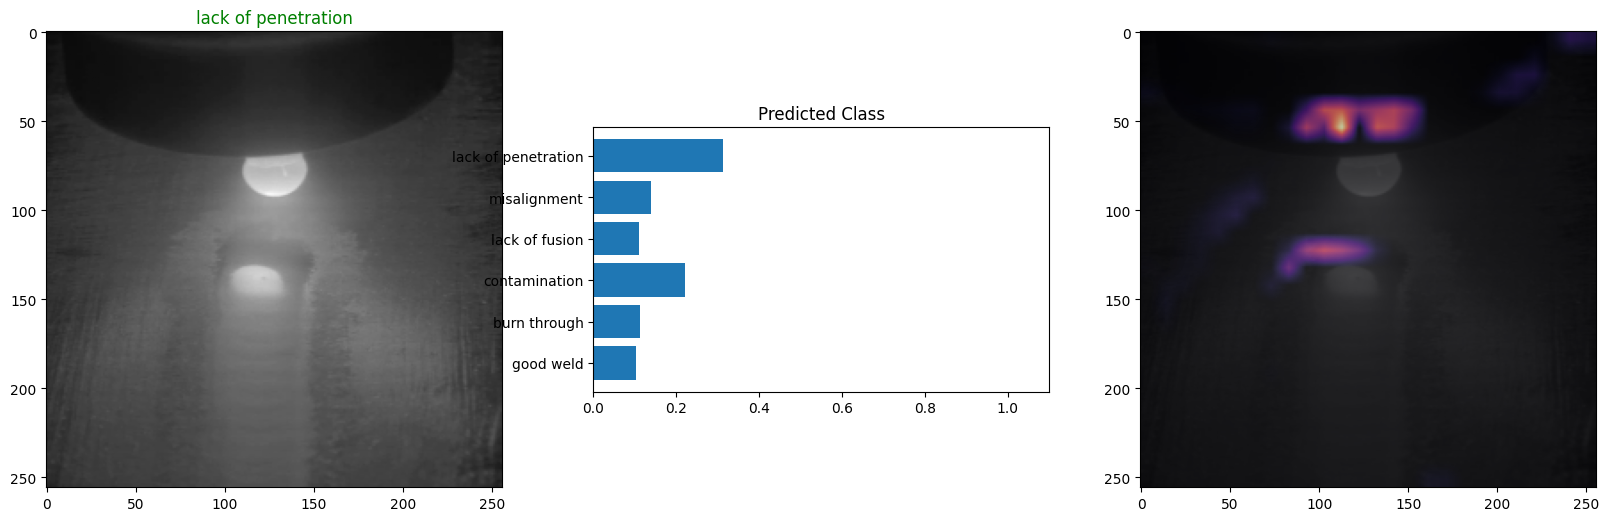

In [94]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[100]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][5],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

# Analyzing the results acheived with GradCam

**Example 1:** The model is able to classify the image and correctly predict the label which is `good weld` and the heatmap is covering parts of the region of interest well **which tells us that that model has learned the features and the region of interest is highlighted as well.**

**Example 2 :** The model is also able to classify this example and correctly predict the label which is `burn through` here the **heatmap is visible in the image and is seen covering the image around the defect highlighting its uniqueness**

**Example 3:** The model is also able to classify this example and correctly predict the label which is `misalignment` here the **heatmap is visible in the image and is seen highlighting the main region of defect**

**Example 4:** The model is able to classify the image and correctly predict the label which is `lack of fusion` **heatmap is visible in the image and is seen highlighting the main region of defect**

**Example 5:** The model is able to classify the image and correctly predict the label which is `contamination` and **the heatmap is also covering most regions of the defect.**

**Example 6:** The model is able to classify the image and correctly predict the label which is `lack of penetration` **the heatmap is also visible and is highlighting the main region of the defect.**


The analysis from these examples tells us that model being able to classify the images with 98% accuracy. In all the examples the model is seen highlighting the defect well with gradcam and also classified all the examples correctly. 

*The difference between CNN and QCNN here is that QCNN is able to learn the features of the image as we can see in the resulting heatmaps obtained. The classification of labels is improved and better results were obtained than the previous QCNN model, increasing the epochs allowed the model to learn the features and also emphasize on the main features that is the defect.This experiment was necessary to understand how the model is learning the features of the images and how a single Quantum Layer helped the model to give better and relaible performance than CNN*

In [83]:
def check_accuracy(loader, model):
        num_correct = 0
        num_samples = 0
        preds = []
        y_true = []
        model.eval()

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)
                scores = model(x)
                _, predictions = scores.max(1)
                num_correct += (predictions == y.squeeze()).sum()
                num_samples += predictions.size(0)
                
                preds.append(scores.to('cpu'))
                y_true.append(y.to('cpu'))
                
            acc = float(num_correct)/float(num_samples)*100
            print(f'Got {num_correct} / {num_samples} with accuracy {acc:.2f}')
        
        model.train()
        
        metrica = MulticlassAccuracy(num_classes=6)
        metricp = MulticlassPrecision(num_classes=6)
        metricr = MulticlassRecall(num_classes=6)
        metricf = MulticlassF1Score(num_classes=6)
        
        metricat = MulticlassAccuracy(num_classes=6,average=None)
        metricpt = MulticlassPrecision(num_classes=6,average=None)
        metricrt = MulticlassRecall(num_classes=6,average=None)
        metricft = MulticlassF1Score(num_classes=6,average=None)
        
        print('Total Accuracy :', metrica(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print('Total Precision :', metricp(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print('Total Recall :', metricr(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print('Total F1-score :', metricf(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print()
        print('Accuracy for Each Classes:', metricat(torch.cat(preds), torch.cat(y_true)) * 100)
        print('Precision for Each Classes:', metricpt(torch.cat(preds), torch.cat(y_true)) * 100)
        print('Recall for Each Classes:', metricrt(torch.cat(preds), torch.cat(y_true)) * 100)
        print('F1-score for Each Classes:', metricft(torch.cat(preds), torch.cat(y_true)) * 100) 

In [84]:
check_accuracy(test_loader,model)

Got 3898 / 3949 with accuracy 98.71
Total Accuracy : 98.72944951057434
Total Precision : 98.73359203338623
Total Recall : 98.72944951057434
Total F1-score : 98.72851371765137

Accuracy for Each Classes: tensor([ 96.7115, 100.0000,  97.7578,  99.8505,  99.1031,  98.9537])
Precision for Each Classes: tensor([ 98.1791, 100.0000,  98.7915, 100.0000,  97.3568,  98.0741])
Recall for Each Classes: tensor([ 96.7115, 100.0000,  97.7578,  99.8505,  99.1031,  98.9537])
F1-score for Each Classes: tensor([ 97.4398, 100.0000,  98.2720,  99.9252,  98.2222,  98.5119])


In [85]:
import pickle as pkl
with open('/kaggle/working/QCNN_results.pkl','wb') as f:
    pkl.dump(useful_stuff,f)

In [86]:
def plot_CM(loader, model):
        num_correct = 0
        num_samples = 0
        preds = []
        y_true = []
        model.eval()

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)
                scores = model(x)
                _, predictions = scores.max(1)
                num_correct += (predictions == y.squeeze()).sum()
                num_samples += predictions.size(0)
                
                preds.append(scores.to('cpu'))
                y_true.append(y.to('cpu'))
                
            acc = float(num_correct)/float(num_samples)*100
            print(f'Got {num_correct} / {num_samples} with accuracy {acc:.2f}')
        
        metric = MulticlassConfusionMatrix(num_classes=6)
        metric.update(torch.cat(preds), torch.cat(y_true))
        fig_, ax_ = metric.plot()
        
        model.train()

# Confusion Matrix

Got 3898 / 3949 with accuracy 98.71


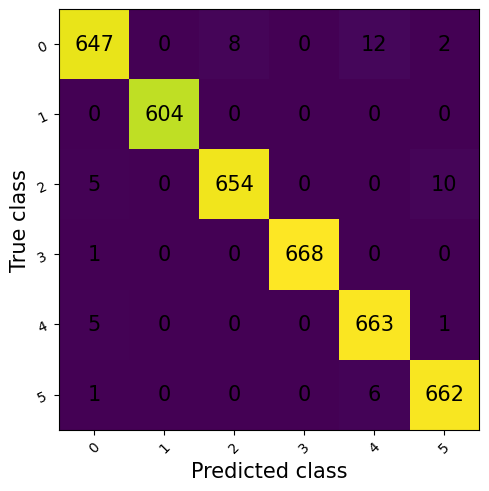

In [87]:
plot_CM(test_loader, model)